In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Dropout,Dense, LSTM,TimeDistributed, RepeatVector
from keras.models import Sequential

In [24]:
import os, glob
files_folder = "problem1/"
files = []
for file in glob.glob(os.path.join(files_folder ,"*.txt")):
                      table = pd.read_csv(file , delimiter=',',names=['Doing nothing', 'Eating', 'Ruminating','Walking'], index_col=False)
                      files.append(table)


df = pd.concat(files, keys=['cow {}'.format(i+1) for i in range(len(files))])
df

Doing nothing    Eating  Ruminating   Walking
cow 1  0          0.163131  0.499941    0.000000  0.336928
       1          0.098108  0.650174    0.020977  0.230742
       2          0.550739  0.335149    0.007132  0.106980
       3          0.065699  0.622836    0.074481  0.236985
       4          0.457155  0.318455    0.057907  0.166483
...                    ...       ...         ...       ...
cow 11 5995       0.060640  0.021277    0.903936  0.014147
       5996       0.116282  0.049385    0.778037  0.056296
       5997       0.701440  0.014866    0.239034  0.044660
       5998       0.964299  0.014280    0.007140  0.014280
       5999       0.649368  0.057426    0.228613  0.064593

[66000 rows x 4 columns]

In [25]:
# selecting data of one cow as normal data for feeding to our model
#based on clustering model and data visualiztion, I have noticed that data of cow 3 has less anomalities,
#so i assumed data for this cow as relativly normal data.
train=df.loc['cow 3']
test=df.drop('cow 3')

In [26]:
#this is a lSTM autoencoder,so I need a lookback function for sequencing the data.
#I used LSTM for considering time dependencies.
#as data from sensors is collected every 15 minutes,I decided to take TIME_STEPS = 8, which means that I am analyzing
#the data of cows by considering cow’s behavior during 2 hours.

def create_dataset(X,y, time_steps):
    X1, y1= [],[]
    for i in range(len(X) - time_steps):
        X1.append(X.iloc[i:(i+time_steps)].values)
        y1.append(y.iloc[i+time_steps:i+time_steps+1].values)
        
    return np.array(X1), np.array(y1)
TIME_STEPS = 8
X_train,y_train = create_dataset(train,train, TIME_STEPS)

print(X_train.shape)

(5992, 8, 4)


In [27]:
#LSTM Autoencoder model
model = Sequential()
model.add(LSTM(128, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, activation='relu',return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu',return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 128)            68096     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 8, 64)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8, 64)             33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 8, 128)            98816     
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 128)           

In [28]:
history=model.fit(X_train, X_train, epochs=20, batch_size=100, verbose=0, validation_split=0.1).history

Text(0, 0.5, 'Loss')

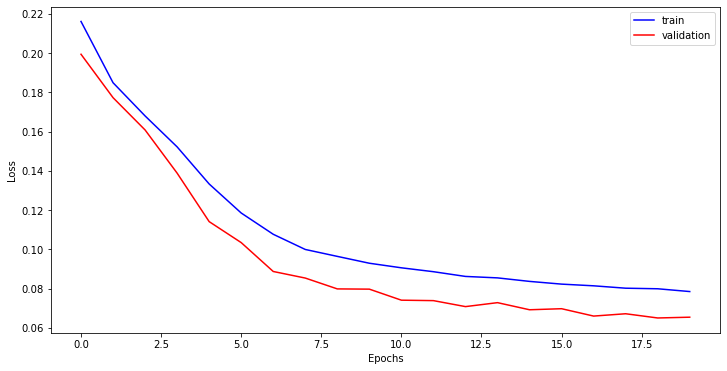

In [29]:
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(history['loss'],'b', label='train')
ax.plot(history['val_loss'],'r', label='validation')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

reconstruction loss threshold: 0.18075715460378167


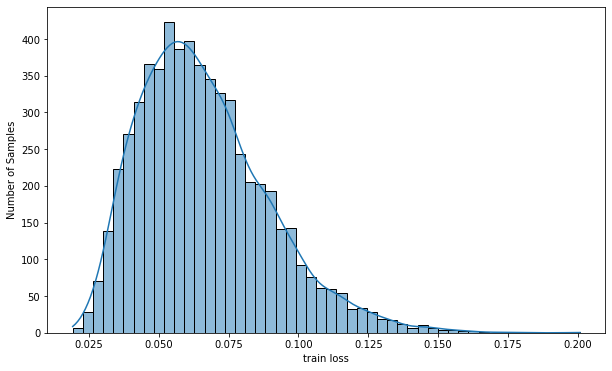

In [30]:
#plotting the distribution of the calculated loss in the training set for determining a suitable threshold value for 
#identifying an anomaly. 
#this threshold should be above the noise level. I assumed that losses above 90 percentile are noises.

X_train_pred=model.predict(X_train)
train_loss=np.mean(np.abs(X_train_pred-X_train), axis=1)

train_loss=pd.DataFrame(train_loss, columns=['Doing nothing', 'Eating', 'Ruminating','Walking'])
train_loss=train_loss.mean(axis=1)
plt.figure(figsize=(10,6))
sns.histplot(train_loss,bins=50, kde=True)
plt.xlabel('train loss')
plt.ylabel('Number of Samples')


threshold = np.max(train_loss)*0.9
print('reconstruction loss threshold: {}'. format(threshold))



 anomalis for cow 9 = 2: 
     Doing nothing    Eating  Ruminating   Walking    cow      loss  anomaly
459       0.637125  0.028368    0.320324  0.014184  cow 9  0.182975     True
969       0.069124  0.021259    0.866972  0.042645  cow 9  0.181099     True

 anomalis for cow 7 = 102: 
      Doing nothing    Eating  Ruminating   Walking    cow      loss  anomaly
79         0.034777  0.123016    0.808115  0.034091  cow 7  0.210437     True
119        0.004483  0.863845    0.062466  0.069206  cow 7  0.188182     True
123        0.310969  0.007209    0.638510  0.043312  cow 7  0.211756     True
124        0.938657  0.007651    0.015302  0.038391  cow 7  0.206668     True
209        0.034973  0.266540    0.677538  0.020950  cow 7  0.186529     True
...             ...       ...         ...       ...    ...       ...      ...
5767       0.589544  0.007157    0.396143  0.007157  cow 7  0.208259     True
5768       0.038225  0.041370    0.878979  0.041426  cow 7  0.202573     True
5770       

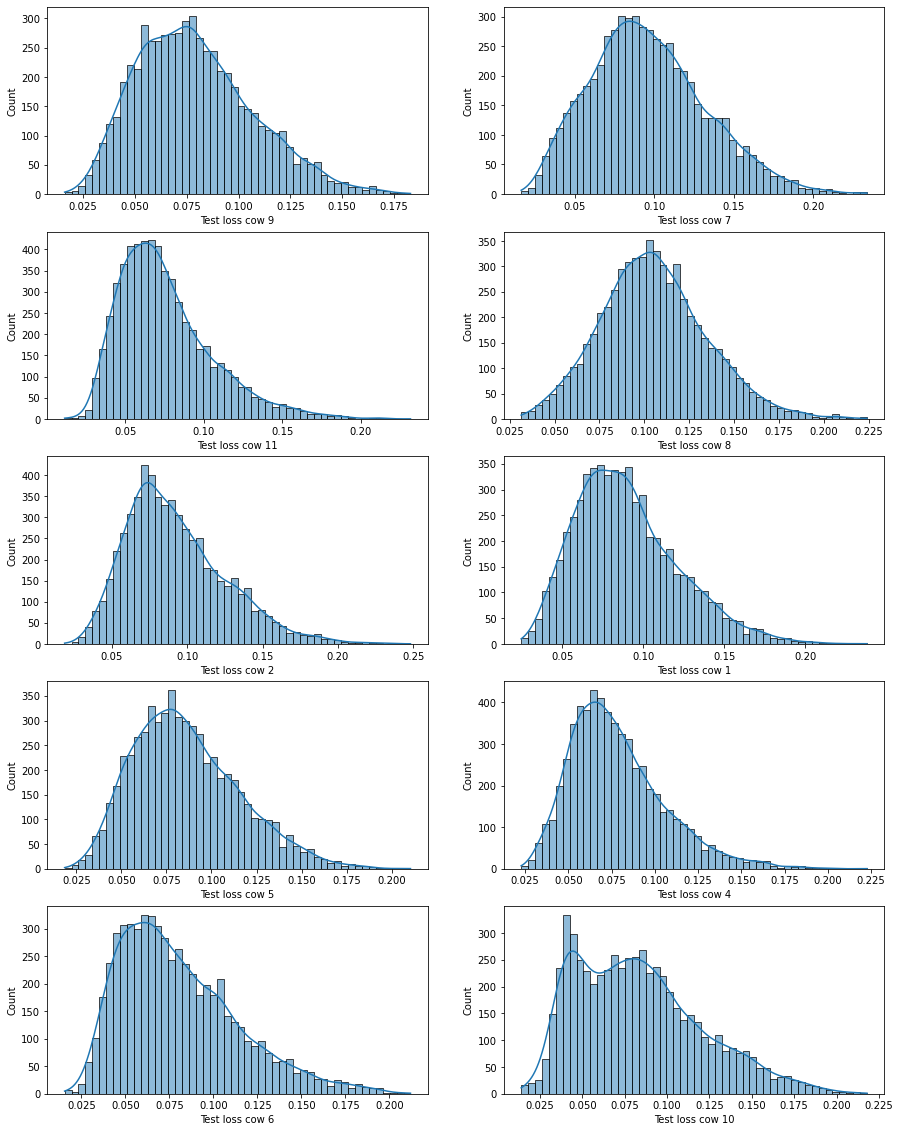

In [31]:
#calculating the reconstruction loss in the test sets to determine when the sensor readings cross the anomaly threshold.
#I took data for each cow as separate test set to analyze each cow behavior and find anomalies for each of them separately,
#to be able to compare their behavior.
test_data_index=list(set(test.index.get_level_values(0)))
fig, subaxes = plt.subplots(5, 2, figsize=(15,20))
anomalies_total_list=[]
for i in range(len(test_data_index)):
    test_df=df.loc[test_data_index[i]]
    X_test,y_test= create_dataset(test_df,test_df,TIME_STEPS)
    X_test_pred = model.predict(X_test)
    test_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)
    test_loss=pd.DataFrame(test_loss, columns=['Doing nothing', 'Eating', 'Ruminating','Walking'])
    test_loss['loss']=test_loss.mean(axis=1)
    plt.subplot(5,2,i+1)
    sns.histplot(test_loss['loss'],bins=50,kde=True)
    plt.xlabel('Test loss {}'.format(test_data_index[i]))
    
    
    
    test_score_df = pd.DataFrame(test_df[TIME_STEPS:])
    test_score_df['cow']=test_data_index[i]
    test_score_df['loss'] = test_loss['loss']
    test_score_df['anomaly'] = test_score_df['loss'] >threshold
    anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
    print('\n anomalis for {} = {}: \n{}'.format(test_data_index[i],len(anomalies), anomalies))
    anomalies_total_list.append(anomalies)
    
    

In [32]:
anomalies_total=pd.concat(anomalies_total_list)
anomalies_total

,Doing nothing,Eating,Ruminating,Walking,cow,loss,anomaly
459,0.637125,0.028368,0.320324,0.014184,cow 9,0.182975,True
969,0.069124,0.021259,0.866972,0.042645,cow 9,0.181099,True
79,0.034777,0.123016,0.808115,0.034091,cow 7,0.210437,True
119,0.004483,0.863845,0.062466,0.069206,cow 7,0.188182,True
123,0.310969,0.007209,0.638510,0.043312,cow 7,0.211756,True
...,...,...,...,...,...,...,...
5792,0.035276,0.000000,0.943849,0.020875,cow 10,0.186246,True
5893,0.102325,0.020739,0.870023,0.006913,cow 10,0.185044,True
5907,0.152727,0.069126,0.750563,0.027583,cow 10,0.202416,True
5909,0.020958,0.146896,0.635669,0.196478,cow 10,0.181223,True


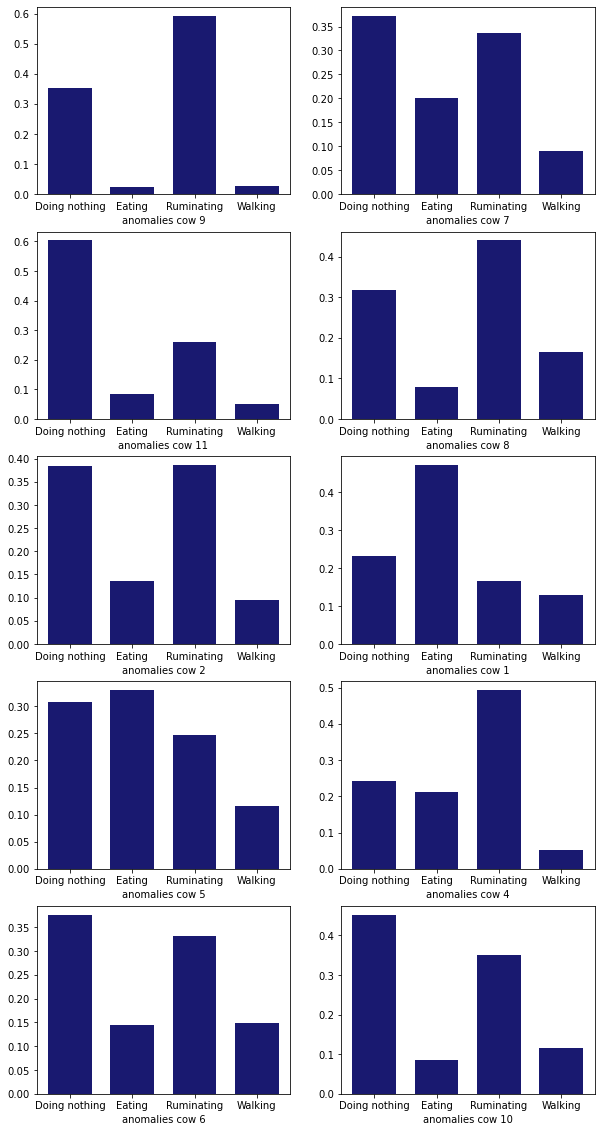

In [33]:
# anomalies in different cows are different. in some cases 'eating' decrease,
#in some other cases 'doing nothing' increase , ... 
fig, subaxes = plt.subplots(5, 2, figsize=(10,20))
for i in range(len(test_data_index)):
    plt.subplot(5,2,i+1)
    plt.bar(x=['Doing nothing', 'Eating', 'Ruminating','Walking'],
            height=list(anomalies_total[['Doing nothing', 'Eating', 'Ruminating','Walking']][anomalies_total['cow']==test_data_index[i]].mean(axis=0))
           ,width=0.7, color='#191970')
    plt.xlabel('anomalies {}'.format(test_data_index[i]))
    

    